<a href="https://colab.research.google.com/github/embryonics/algo/blob/shahar/results_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid",
              {"axes.facecolor": ".9"
              })

In [0]:
path ='/content/df_2019-10-01_v3.csv'
#path = '/content/Data_Ukraine_Nadiya_Dataframes_Ukraine_Full_df_2019-10-01 (2) (1).csv'
#path = '/content/model_2019-07-17_results.csv'

In [0]:
df = pd.read_csv(path)

In [0]:
PREDICTIONS = ['prediction']
#PREDICTIONS = ['prediction_old', 'prediction_new']
PANELISTS = ['g_natali', 'g_olga']
IMPLANT = ['implant']
OTHER = [ 'uniq', 'name', 'well', 'ferti_date', 'birth_date']

**filter the df**

In [0]:
df = df[df.columns[df.columns.isin(PREDICTIONS + PANELISTS + IMPLANT + OTHER)]]

In [474]:
df.head()

,uniq,name,well,ferti_date,birth_date,prediction,implant,g_natali,g_olga
0,S0025_W1,S0025,1,3/22/2012,1/1/1974,NaN,NaN,3.0,NaN
1,S0025_W10,S0025,10,3/22/2012,1/1/1974,NaN,NaN,5.0,NaN
2,S0025_W2,S0025,2,3/22/2012,1/1/1974,NaN,NaN,3.0,NaN
3,S0025_W3,S0025,3,3/22/2012,1/1/1974,NaN,NaN,1.0,NaN
4,S0025_W4,S0025,4,3/22/2012,1/1/1974,NaN,NaN,4.0,NaN


functions

In [0]:
def threshold_prediction(df, predictions):
  for prediction in predictions:
    df[prediction] = df[prediction].apply(lambda x: 1 if x >=0.5 else 0)
  return df

In [0]:
def generate_panel(df,panelists):
  df['panel'] = df[panelists].mean(axis=1)
  df = df.drop(panelists, axis=1)
  df.dropna(axis=0, inplace=True)
  df['panel'] = df['panel'].apply(lambda x: 1 if x >= 4 else 0)
  return df

In [0]:
def compute_age(df, birth_date, ferti_date):
  df[birth_date] = pd.to_datetime(df[birth_date])
  df[ferti_date] = pd.to_datetime(df[ferti_date])
  df['age'] = (df[ferti_date] - df[birth_date]).dt.days/365
  df.drop([ferti_date, birth_date], axis=1, inplace=True)
  return df

In [0]:
def compute_metrics(df, predictions):

  results_dict = {}

  # Clinic
  tp_c = df['implant'].sum()
  positives_c = df['implant'].count() # all the implanted were selected
  ppv_c = tp_c / float(positives_c)

  # Panel
  tp_p = df[(df['panel'] == 1) & (df['implant'] == 1)]['panel'].count()
  tn_p = df[(df['panel'] == 0) & (df['implant'] == 0)]['panel'].count()
  positives_p = df[(df['panel'] == 1)]['panel'].count()
  negatives_p = df[(df['panel'] == 0)]['panel'].count()
  ppv_p = tp_p / float(positives_p)
  npv_p = tn_p / float(negatives_p)

  # UBar 
  def ubar_metrics(df, predictions):

    p_dict = {}
    
    for p in predictions:
      tp_u = df[(df[p] == 1) & (df['implant'] == 1)][p].count()
      tn_u = df[(df[p] == 0) & (df['implant'] == 0)][p].count()
      positives_u = df[(df[p] == 1)][p].count()
      negatives_u = df[(df[p] == 0)][p].count()
      ppv_u = tp_u / float(positives_u)
      npv_u = tn_u / float(negatives_u)

      p_dict.update({'PPV '+ p : ppv_u, 'NPV ' + p : npv_u})
    return p_dict, p_dict.keys()

  p_dict, predict_names = ubar_metrics(df, predictions)

  results_dict.update({'PPV clinic' : ppv_c,
                       'PPV panel' : ppv_p,
                       'NPV panel' : npv_p
                       })
    
  results_dict.update(p_dict)
  return {'results_dict': results_dict, 'predict_names': predict_names}

          


In [0]:
def data_by_age(df , predictions, verbose = False, cut_low_high_ages = True):

  AGE_WINDOW = 3
  AGE_LOW_CUT = 25
  AGE_HIGH_CUT = 50

  results = pd.DataFrame()

  if cut_low_high_ages:
    ages = range(max(int(df['age'].min()), AGE_LOW_CUT), min(int(df['age'].max()), AGE_HIGH_CUT))
  else:
     ages = range(int(df['age'].min()), int(df['age'].max()))

  for age in ages:
    age_low = age - AGE_WINDOW
    age_high = age + AGE_WINDOW

    df_itr = df[(df['age'] >= age_low) & (df['age']<= age_high)]
    m_dict = compute_metrics(df_itr, predictions)
    m = m_dict['results_dict']
    predict_names = m_dict['predict_names']
    m['n'] = df_itr['age'].count() # sample count
    m['age_group'] = '{} - {}'.format(age_low, age_high)


    if verbose:
      print('age: ', age_low, '-', age_high, ', samples: ', n , m)

    results = pd.concat([results, pd.DataFrame(m, index = range(1))], axis = 0)
    
  return results, predict_names

MAIN

In [0]:
df = threshold_prediction(df, PREDICTIONS)

In [0]:
df = generate_panel(df, PANELISTS)

In [0]:
df = compute_age(df, 'birth_date', 'ferti_date')

In [483]:
compute_metrics(df, PREDICTIONS)

{'predict_names': dict_keys(['PPV prediction', 'NPV prediction']),
 'results_dict': {'NPV panel': 0.2,
  'NPV prediction': 0.5111111111111111,
  'PPV clinic': 0.7857142857142857,
  'PPV panel': 0.7798165137614679,
  'PPV prediction': 0.908256880733945}}

In [0]:
df_metrics,predict_names = data_by_age(df, PREDICTIONS , verbose=False)
df_metrics = df_metrics.reset_index().drop('index', axis=1)

In [485]:
df_metrics.head()

,PPV clinic,PPV panel,NPV panel,PPV prediction,NPV prediction,n,age_group
0,0.500000,0.470588,0.333333,0.500000,0.500000,20,22 - 28
1,0.653846,0.578947,0.142857,0.750000,0.428571,26,23 - 29
2,0.578947,0.500000,0.125000,0.800000,0.565217,38,24 - 30
3,0.651163,0.558824,0.000000,0.888889,0.520000,43,25 - 31
4,0.645833,0.552632,0.000000,0.894737,0.517241,48,26 - 32


In [0]:
def add_diff(df, predictions):

  for p in predictions:
    prefix = '' if len(predictions) == 1 else p
    df[prefix + 'PPV delta [%]'] = ((df['PPV ' + p] - df['PPV panel'])*100).replace(np.inf, 60)
    df[prefix + 'NPV delta [%]'] = ((df['NPV ' + p] - df['NPV panel'])*100).replace(np.inf, 60)

  return df

In [0]:
df_metrics = add_diff(df_metrics, PREDICTIONS)

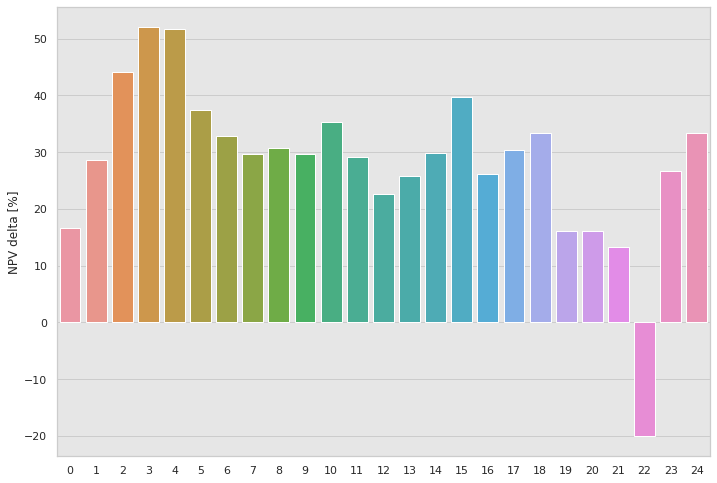

In [526]:
# sns.scatterplot(x = df_metrics.index, y = 'NPV prediction', data = df_metrics)
# sns.scatterplot(x = df_metrics.index, y = 'NPV panel', data = df_metrics)
sns.barplot(x = df_metrics.index, y = 'NPV delta [%]', data = df_metrics)

In [0]:
# df_metrics['age_group'] = df_metrics['age_group'].astype('category') # categorize the age group for plotting purpases

In [444]:
df_metrics.head()

,PPV clinic,PPV panel,NPV panel,PPV prediction,NPV prediction,n,age_group,PPV delta [%],NPV delta [%]
0,0.500000,0.470588,0.333333,0.500000,0.500000,20,22 - 28,2.941176,16.666667
1,0.653846,0.578947,0.142857,0.750000,0.428571,26,23 - 29,17.105263,28.571429
2,0.578947,0.500000,0.125000,0.800000,0.565217,38,24 - 30,30.000000,44.021739
3,0.651163,0.558824,0.000000,0.888889,0.520000,43,25 - 31,33.006536,52.000000
4,0.645833,0.552632,0.000000,0.894737,0.517241,48,26 - 32,34.210526,51.724138


In [0]:
df_melt = df_metrics.drop('n', axis = 1).melt('age_group')

In [446]:
df_melt.head()

,age_group,variable,value
0,22 - 28,PPV clinic,0.500000
1,23 - 29,PPV clinic,0.653846
2,24 - 30,PPV clinic,0.578947
3,25 - 31,PPV clinic,0.651163
4,26 - 32,PPV clinic,0.645833


In [447]:
predict_names

dict_keys(['PPV prediction', 'NPV prediction'])

In [0]:
to_plot_ppv = ['PPV clinic' , 'PPV panel', 'PPV prediction']
to_plot_npv = ['NPV clinic' , 'NPV panel', 'NPV prediction']
to_plot_ppv_new = ['PPV clinic' , 'PPV panel', 'PPV prediction_new']
to_plot_npv_new = ['NPV clinic' , 'NPV panel', 'NPV prediction_new']
to_plot_ppv_old = ['PPV clinic' , 'PPV panel', 'PPV prediction_old']
to_plot_npv_old = ['NPV clinic' , 'NPV panel', 'NPV prediction_old']

In [456]:
df_melt.head()

,age_group,variable,value
0,22 - 28,PPV clinic,0.500000
1,23 - 29,PPV clinic,0.653846
2,24 - 30,PPV clinic,0.578947
3,25 - 31,PPV clinic,0.651163
4,26 - 32,PPV clinic,0.645833


ppv plot

In [0]:
def report(to_plot , metric_type , xlabel, df_metrics, df_melt):
  from matplotlib import gridspec

  fig = plt.figure()
  gs = fig.add_gridspec(1, 9)

  # age distribution (uses df_metrics)
  ax1 = fig.add_subplot(gs[0,0])
  g1 = sns.catplot(y = 'age_group',
                  x='n',
                  data = df_metrics,
                  orient='horizontal',
                  ax=ax1,
                  kind='bar',
                  color='grey')
  ax1.invert_xaxis()
  ax1.set_xlabel('# of patients')

  # results (uses df_melt)
  ax2 = fig.add_subplot(gs[0,1:7])
  g2 = sns.catplot(y = 'age_group',
                  x = 'value',
                  hue = 'variable',
                  data = df_melt[df_melt['variable'].isin(to_plot)],
                  orient = 'horizontal',
                  kind='point',
                  legend_out=False,
                  ax=ax2
                  )
  
  plt.setp(ax2.get_yticklabels(), visible=False)
  ax2.set_ylabel('')
  ax2.set_xlabel(xlabel)

  # diff (uses df_metrics)
  ax3 = fig.add_subplot(gs[0, 7])
  metric = 'PPV delta [%]' if metric_type == 'ppv' else 'NPV delta [%]'
  g3 = sns.catplot(data=df_metrics,
                  y='age_group',
                  x= metric ,
                  kind='bar',
                  orient='horizontal',
                  color='grey',
                  ax=ax3)
  plt.setp(ax3.get_yticklabels(), visible=False)
  ax3.set_ylabel('')
  ax3.set_xlim([0,50])

  # t-test table (uses df_metrics)
  # ax4.add_subplot(gs[0,8])
  # g4 = plt.table(colLabels=df_metrics['n'], rowLabels=df_metrics['age_group'], cellText=df_metrics['n'])


  #close extras
  plt.close(2)
  plt.close(3)
  plt.close(4)

  plt.tight_layout()

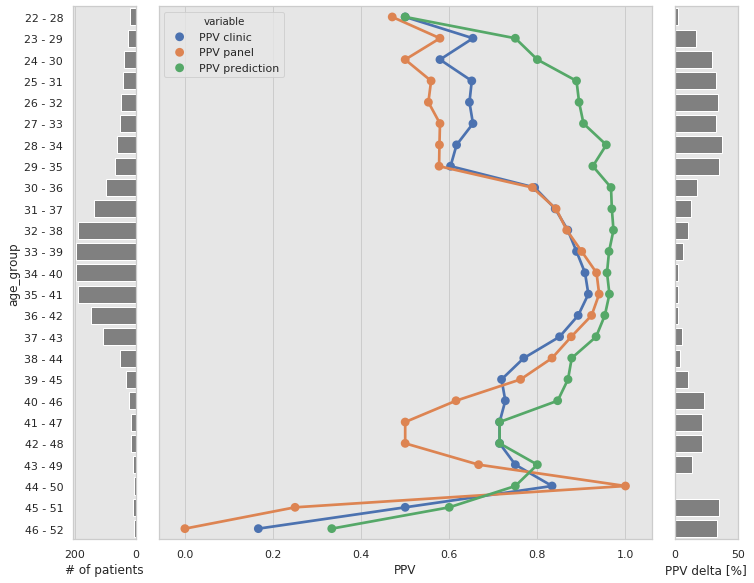

In [510]:
report(to_plot_ppv, 'ppv', 'PPV', df_metrics, df_melt)

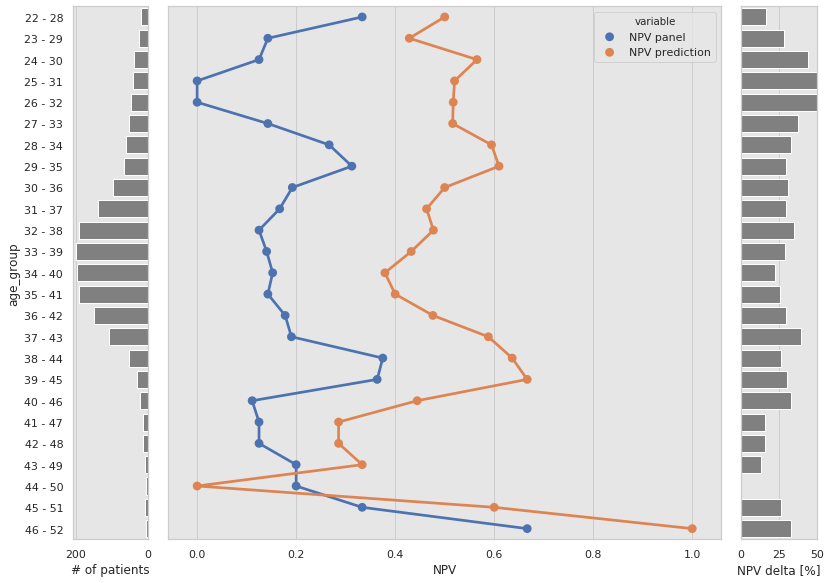

In [465]:
report(to_plot_npv, 'npv', 'NPV', df_metrics, df_melt)